<a href="https://colab.research.google.com/github/JoitaMitra/Stable-Diffusion-Inpainting/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers==0.7.2
!pip install accelerate==0.14.0
!pip install transformers==4.24.0
!pip install scipy ftfy==6.1.1
!pip install "ipywidgets>=7,<8"
!pip install git+https://github.com/openai/CLIP.git@d50d76daa670286dd6cacf3bcd80b5e4823fc8e1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.9/304.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 6.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear', num_train_timesteps=1000)

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['text_projection.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.weight', 'vision_model.encoder.layers.9.self_attn.k_proj.weight', 'vision_model.encoder.layers.2.mlp.fc2.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.8.layer_norm1.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.23.self_attn.k_proj.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.layer_norm1.bias', 'vision_model.encoder.layers.10.mlp.fc1.bias', 'vision_model.encoder.layers.4.mlp.fc2.weight', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_mod

In [ ]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Do the same for unconditional embeddings
  uncond_input = tokenizer([''] * len(prompt), padding='max_length', max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings


In [ ]:
def produce_latents(text_embeddings, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None, return_all_latents=False):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  latent_hist = [latents]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']
      latent_hist.append(latents)
  
  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

In [ ]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents)

  imgs = (imgs.sample / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images

In [ ]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=250, guidance_scale=7.5, latents=None, return_all_latents=False, batch_size=2):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(text_embeds, height=height, width=width, latents=latents, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, return_all_latents=return_all_latents)
  
  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(1, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

INPUT YOUR IMAGINATION:  a red satin cocktail dress


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

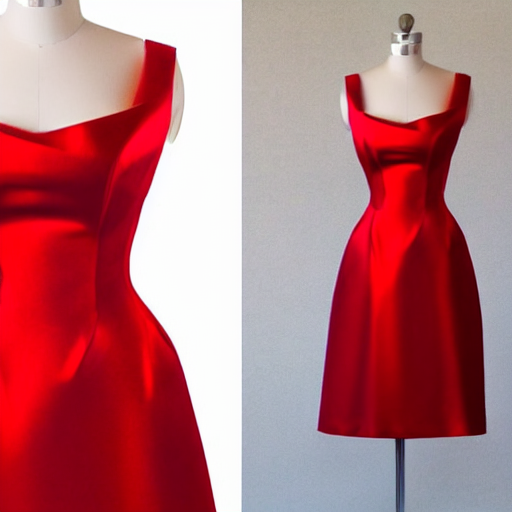

In [ ]:
prompt = input("INPUT YOUR IMAGINATION: ")
#'a golden retriever in a park'
video_frames = prompt_to_img(prompt, num_inference_steps=50, return_all_latents=True)
fin_img = video_frames[-1]
fin_img.save("original.jpg")
fin_img

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

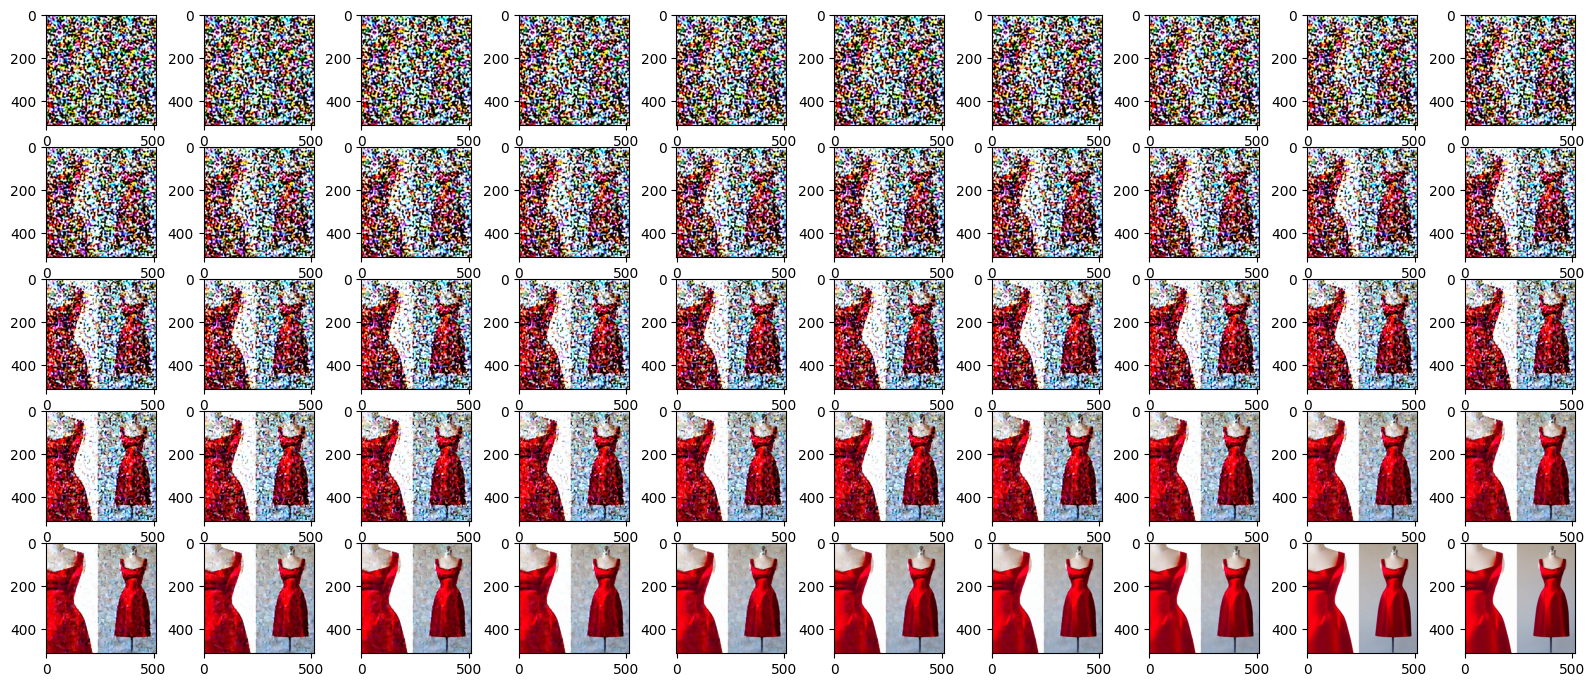

In [ ]:
plt.figure(figsize=(20,10))
columns = 10
for i, image in enumerate(video_frames):
    plt.subplot(int(len(video_frames) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [ ]:
#@title Mask Generation and Inpainting Using GLIDE
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im
!pip install wget --quiet


import base64, os
from IPython.display import HTML, Image, display
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
from shutil import copyfile
import shutil
import ipywidgets as widgets
import wget

from typing import Tuple


from PIL import Image as PIL_IMAGE
import numpy as np
import torch as th
import torch.nn.functional as F



from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

# Create base model.
options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(PIL_IMAGE.fromarray(reshaped.numpy()))

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = PIL_IMAGE.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=PIL_IMAGE.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

canvas_html = """
<style>
.button {
  display: inline-block;
  padding: 15px 40px;
  font-size: 16px;
  cursor: pointer;
  text-align: center;
  text-decoration: none;
  outline: none;
  color: #fff;
  background-color: #8c8c8c;
  border: none;
  border-radius: 10px;
  box-shadow: 0 9px #bfbfbf;
}

.button:hover {background-color: #474747}

.button:active {
  background-color: #339966;
  box-shadow: 0 5px #666;
  transform: translateY(4px);
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>
<br>
<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='image.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


s_prompt = widgets.Textarea(
    value='Please Enter The Correction Needed',
    placeholder='Type your prompt sentence',
    description='Correction Prompt:',
    disabled=False,
    layout={'margin': '25px', 'width': '50%'}
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-2v06uky6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-2v06uky6
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953651 sha256=f0ede7192fb60f0e2bd8442143fae797baf8c62a32dec9928205dc95fc38ea96
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xhoo9jx/wheels/cc/42/3d/790d8f0abca255464f9a334fa07dc75cea93b19ee3834567f9
Successfully built glide-text2im
  Preparing metadata (setup.py) ... done


  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385037638


  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398368198


Textarea(value='a black dress', description='Correction Prompt:', layout=Layout(margin='25px', width='50%'), p…

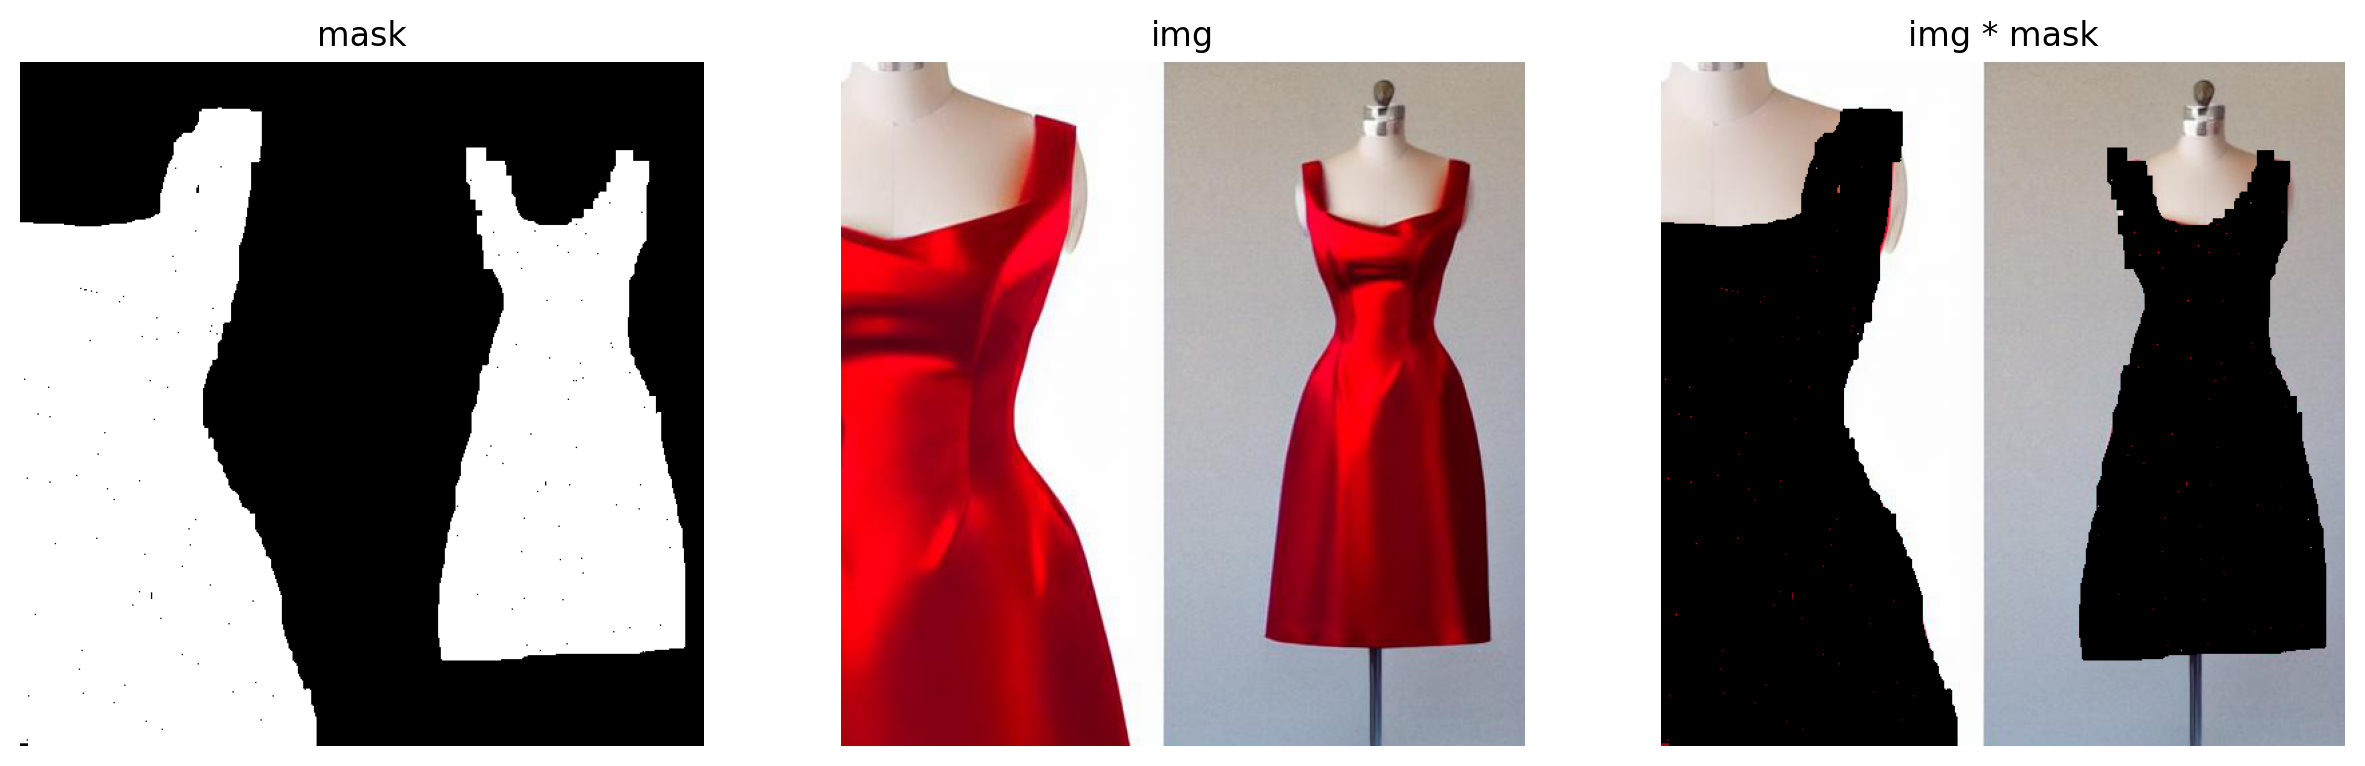

Running Inpainting


  0%|          | 0/100 [00:00<?, ?it/s]

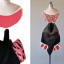

  0%|          | 0/27 [00:00<?, ?it/s]

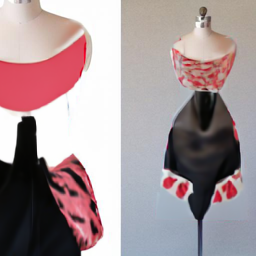

In [ ]:
fname = '/content/original.jpg'

# if fname is None or fname == '':
#   from google.colab import files
#   files = files.upload()
#   fname = list(files.keys())[0]
# else:
#fname = cv2.imread('/content/image.png')
  #fname = wget.download(fname)

# fname

# shutil.rmtree('./data_for_prediction', ignore_errors=True)
# ! mkdir data_for_prediction

# copyfile(str(fname), f'./data_for_prediction/{fname}')
# os.remove(fname)
# fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

img = np.array(plt.imread(f'{fname}')[:,:,:3])

display(s_prompt)
draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.05*img.shape[1])

# Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('Running Inpainting')

# Sampling parameters
prompt = str(s_prompt.value)
batch_size = 1
guidance_scale = 5.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

# Source image we are inpainting
source_image_256 = read_image(fname, size=256)
source_image_64 = read_image(fname, size=64)

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.

source_mask_64 = read_image(f"./{fname.split('.')[1]}_mask.png",size=64)[:, :1]
source_mask_64[source_mask_64 > 0] = 0
source_mask_64[source_mask_64 < 0] = 1
source_mask_256 = F.interpolate(source_mask_64, (256, 256), mode='nearest')


##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image
    inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
)

# Create an classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)


##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image.
    inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.p_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

In [ ]:
%%bash

git clone https://github.com/nickersonj/text-inpainting
mv text-inpainting/images text-inpainting/*py text-inpainting/*ipynb text-inpainting/*txt .
git clone https://github.com/timojl/clipseg/
wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
unzip -d weights -j weights.zip

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


Cloning into 'text-inpainting'...
Cloning into 'clipseg'...
--2023-04-24 06:17:57--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

     0K .......... .......... .......... .......... ..........  216K
    50K .......... .......... .......... .......... ..........  436K
   100K .......... .......... .......... .......... .......... 29.9M
   150K .......... .......... .......... .......... ..........  434K
   200K .......... .......... .......... .......... ..........  128M
   250K .......... .......... .......... .......... .......... 66.3M
   300K .......... .......... .......... .......... .......... 43.7M
   350K .......... .......... .......... .......... ..........  444K
   400K .......... .......... .......... .....

In [ ]:
from masking_inpainting import *

Enter the mask prompt: dress
Enter the inpaint prompt: a black gown
Image Segmentation:


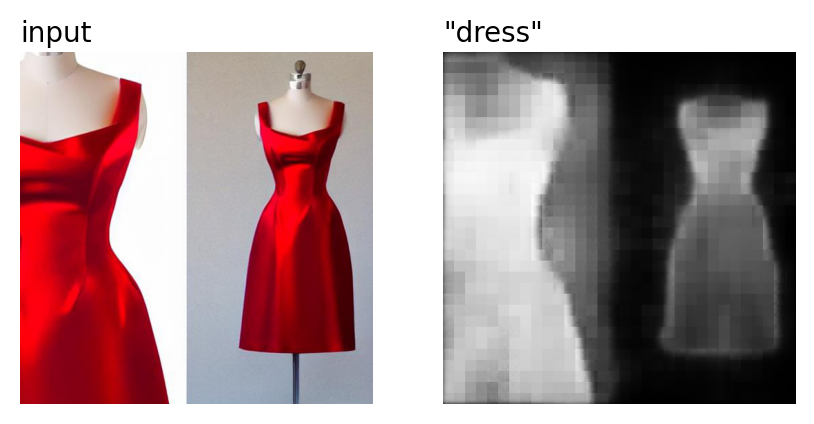

Mask Generation:


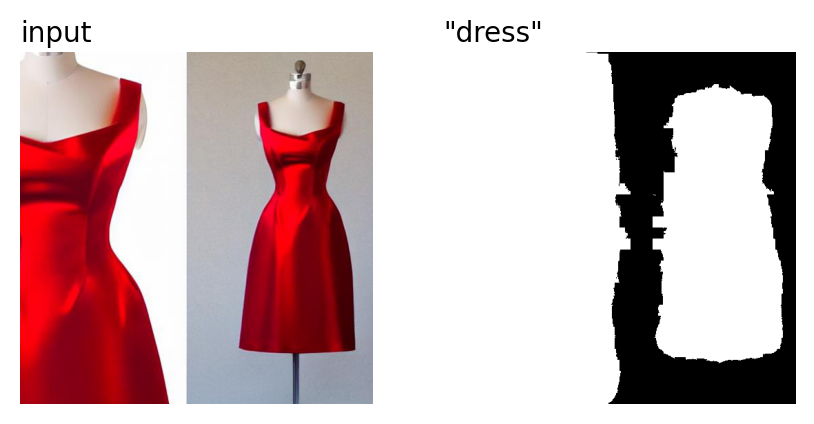

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Result:


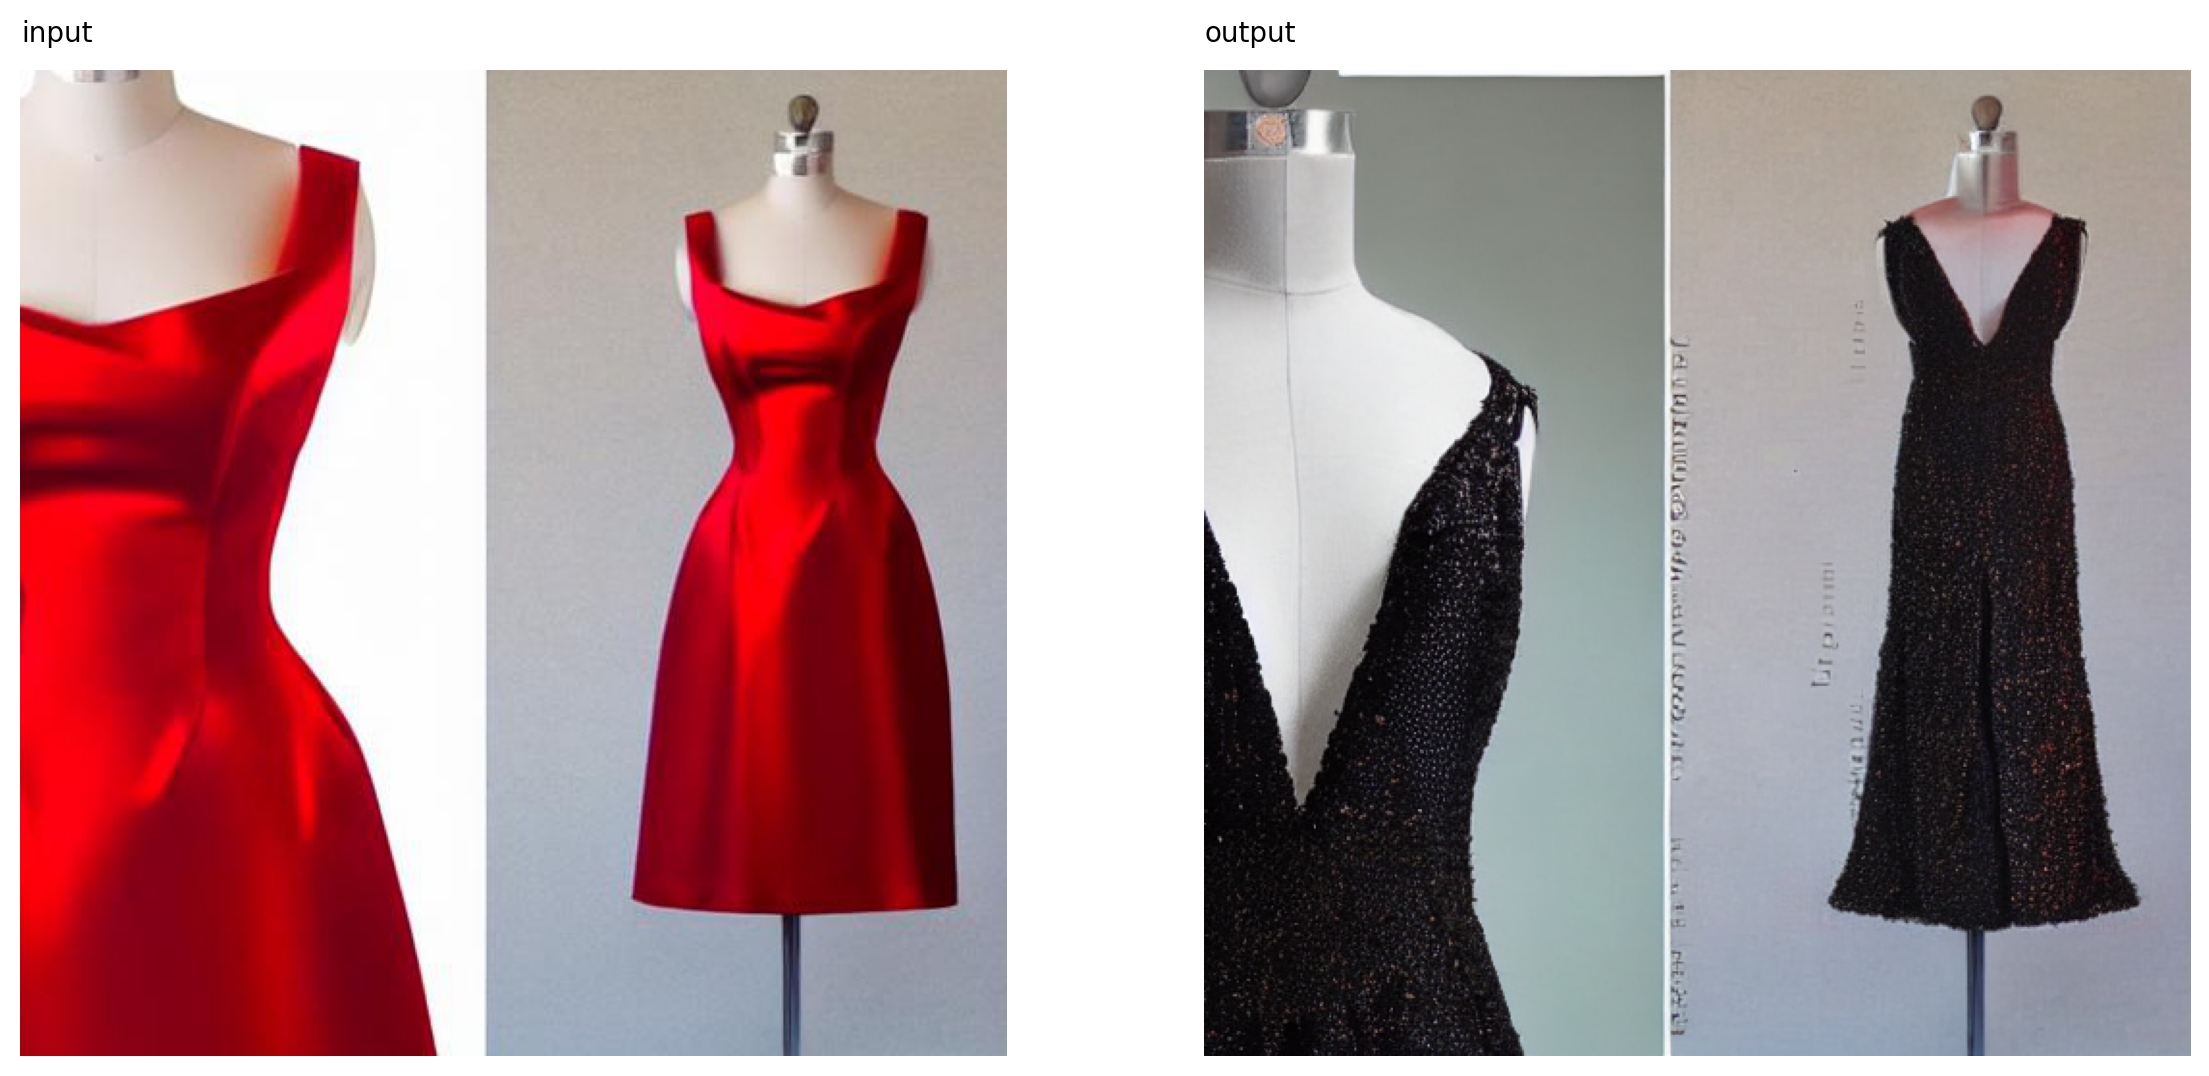

In [ ]:
input_filepath = '/content/original.jpg'
mask_prompt = input("Enter the mask prompt: ")
inpaint_prompt = input("Enter the inpaint prompt: ")

output_image = mask_and_inpaint(input_filepath, mask_prompt, inpaint_prompt, verbose=2)

In [ ]:
output_image.save("inpainted.jpg")

**SSIM**

In [ ]:
from skimage.metrics import structural_similarity
import cv2
import numpy as np

before = cv2.imread('/content/original.jpg')
after = cv2.imread('/content/inpainted.jpg')

# Convert images to grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Compute SSIM between two images
(score, diff) = structural_similarity(before_gray, after_gray, full=True)
print("Image similarity", score)

Image similarity 0.7509186166336285


**LPIPS**

In [ ]:
!git clone https://github.com/richzhang/PerceptualSimilarity

Cloning into 'PerceptualSimilarity'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (775/775), done.
remote: Compressing objects: 100% (316/316), done.
remote: Total 778 (delta 457), reused 774 (delta 456), pack-reused 3
Receiving objects: 100% (778/778), 8.75 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (457/457), done.


In [ ]:
%cd PerceptualSimilarity/
# !pip install -r requirements.txt

/content/PerceptualSimilarity


In [ ]:
!python lpips_2imgs.py -p0 /content/original.jpg -p1 /content/inpainted.jpg --use_gpu

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100% 233M/233M [00:00<00:00, 259MB/s]
Loading model from: /content/PerceptualSimilarity/lpips/weights/v0.1/alex.pth
Distance: 0.161
